In [3]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset, num2date
import math
import matplotlib.colors as mcolors
import numpy.ma as ma

In [8]:
def merc_x(lon):
  r_major=6378137.000
  return r_major*math.radians(lon)

def merc_y(lat):
  if lat>89.5:lat=89.5
  if lat<-89.5:lat=-89.5
  r_major=6378137.000
  r_minor=6356752.3142
  temp=r_minor/r_major
  eccent=math.sqrt(1-temp**2)
  phi=math.radians(lat)
  sinphi=math.sin(phi)
  con=eccent*sinphi
  com=eccent/2
  con=((1.0-con)/(1.0+con))**com
  ts=math.tan((math.pi/2-phi)/2)/con
  y=0-r_major*math.log(ts)
  return y

In [3]:
def loadData(path,type="nc"):
    if type == "nc":
        data = Dataset(path, 'r')
        return data
    
        

In [4]:
ncfile = Dataset('./glo12_rg_1d-m_20240118-20240118_3D-uovo_fcst_R20240117.nc', 'r')


In [5]:
lon = np.asarray(ncfile.variables['longitude'][:])
lat = np.asarray(ncfile.variables['latitude'][:])
u0 = np.asarray(ncfile.variables['uo'][0,0,:,:])
v0 = np.asarray(ncfile.variables['vo'][0,0,:,:])
u0 = np.where(u0 == 9.96921e+36,np.nan, u0)
v0 = np.where(v0 == 9.96921e+36,np.nan, v0)
# ncfile.variables.keys()

array([-180.     , -179.91667, -179.83333, ...,  179.75   ,  179.83334,
        179.91669], dtype=float32)

In [6]:
lon_condition = np.logical_and(lon >= 110, lon <= 132)
lat_condition = np.logical_and(lat >= 15, lat <= 30)
new_lon = lon[lon_condition]
new_lat = lat[lat_condition]

In [11]:
# i want to plot lon > 110 and lon < 130
x=[];y=[]
for l in new_lon:
    x = np.append(x,merc_x(l))
for l in new_lat:
    y = np.append(y,merc_y(l))
#<-calculate the hole domain
new_u0 = u0[:,lon_condition]
new_u0 = new_u0[lat_condition,:]
# new_v0
new_v0 = v0[:,lon_condition]
new_v0 = new_v0[lat_condition,:]
# new speed
new_speed = np.sqrt(new_u0**2 + new_v0**2)
new_speed = np.where(new_speed == 9.96921e+36,np.nan, new_speed)
new_vector = np.stack((new_u0,new_v0),axis=2)
np.shape(new_u0)

(181, 265)

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [12]:
def plot_ocean_current(u,v,lon,lat,dx,width=0.005):
    w=6*2*2/4
    h=w*float(u.shape[0])/float(u.shape[1])
    plt.figure(figsize=(w,h),dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    #make a empty mask to let the quiver tight with edge
    ax.contourf([lon.min(),lon.max()],[lat.min(),lat.max()],np.zeros((2,2)),alpha=0)
    Q = ax.quiver(lon[:-1:dx],lat[:-1:dx],u[:-1:dx,:-1:dx],v[:-1:dx,:-1:dx],angles="xy",width=width)
    ax.quiverkey(Q,0.09,0.9,2,'2m/s',fontproperties={'size': 10})
    ax.add_feature(cfeature.LAND, color='green')  # Add this line to color the land in green

# ax.set_extent([110, 132, 15, 32], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.axis('off')

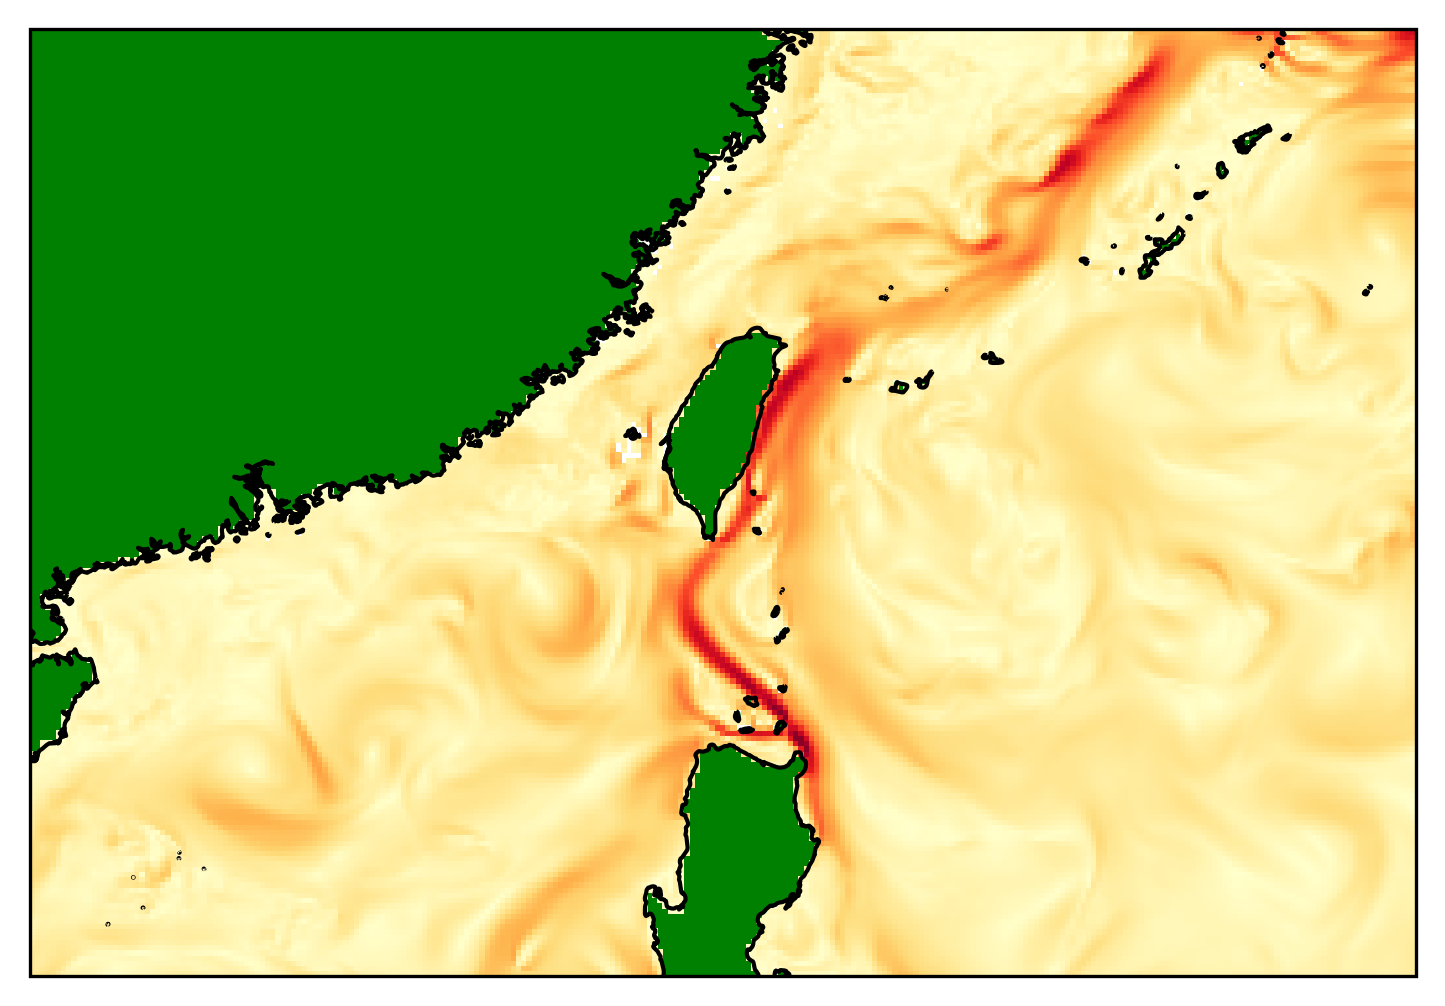

In [15]:
w=6*2*2/4
h=w*float(new_u0.shape[0])/float(new_u0.shape[1])
plt.figure(dpi=300,figsize=(w,h))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.pcolor(new_lon,new_lat,new_speed, cmap='YlOrRd',transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='green')  # Add this line to color the land in green

# ax.set_extent([110, 132, 15, 32], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
# plt.axis('off')

/home/brian/test/weather/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


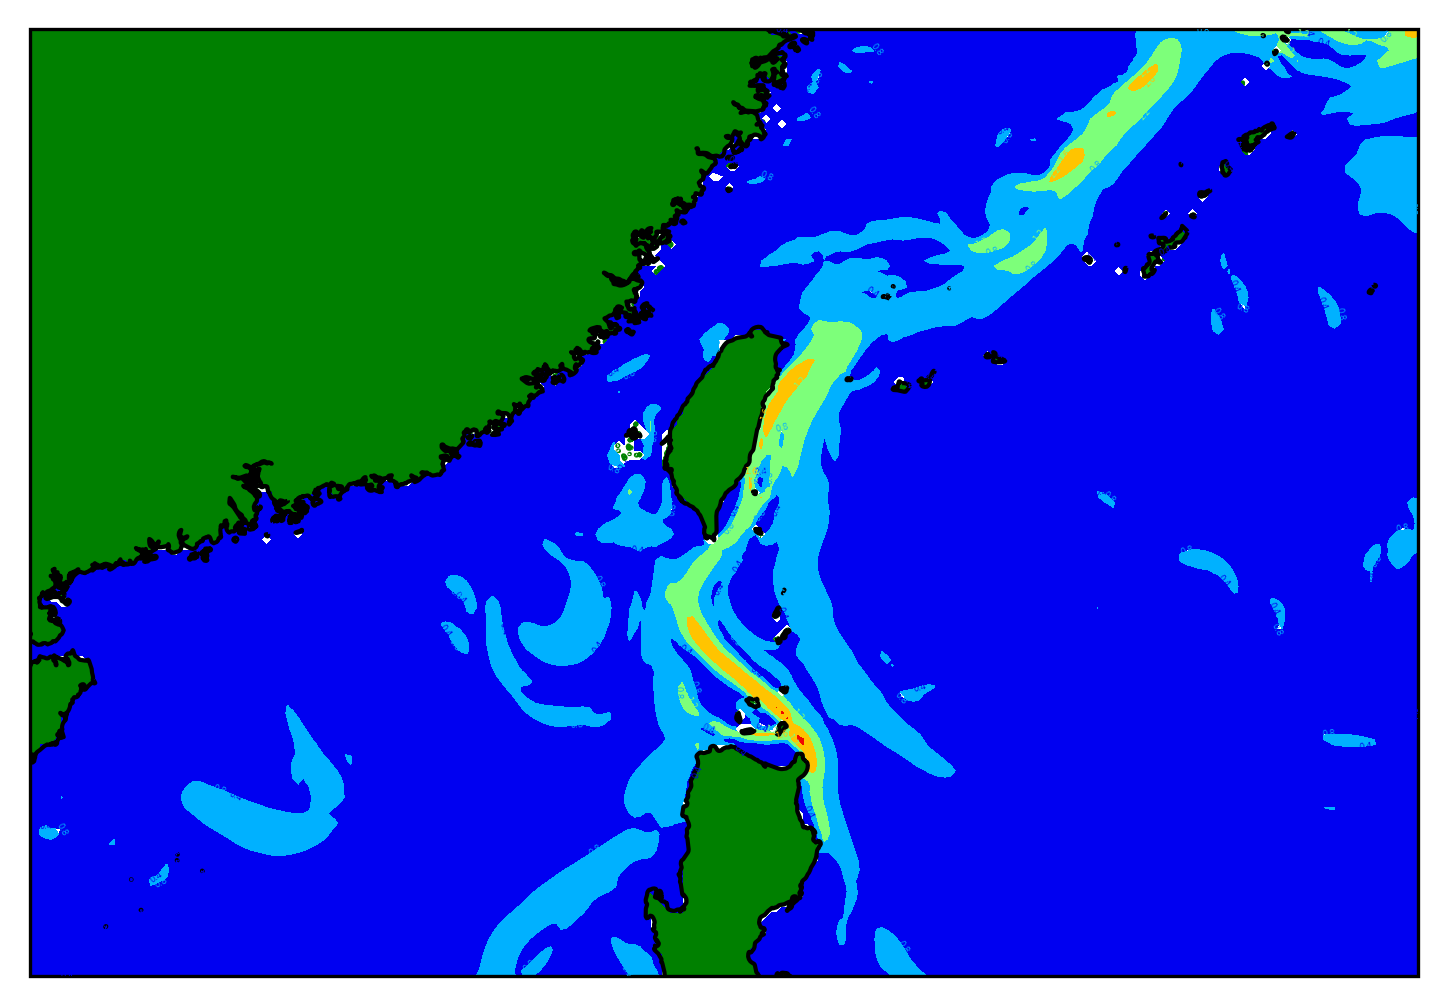

In [14]:
w=6*2*2/4
h=w*float(new_u0.shape[0])/float(new_u0.shape[1])
plt.figure(dpi=300,figsize=(w,h))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.linspace(int(np.nanmin(new_speed)),int(np.nanmax(new_speed))+1,6)
CS = ax.contour(new_lon,new_lat,new_speed,levels,alpha=1, extend='both',linewidths=0.4,cmap='jet',transform=ccrs.PlateCarree())
ax.clabel(CS, inline=True,fmt='%1.1f',inline_spacing=0, fontsize=2)
ax.add_feature(cfeature.LAND, color='green')  # Add this line to color the land in green

# ax.set_extent([110, 132, 15, 32], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
# plt.axis('off')

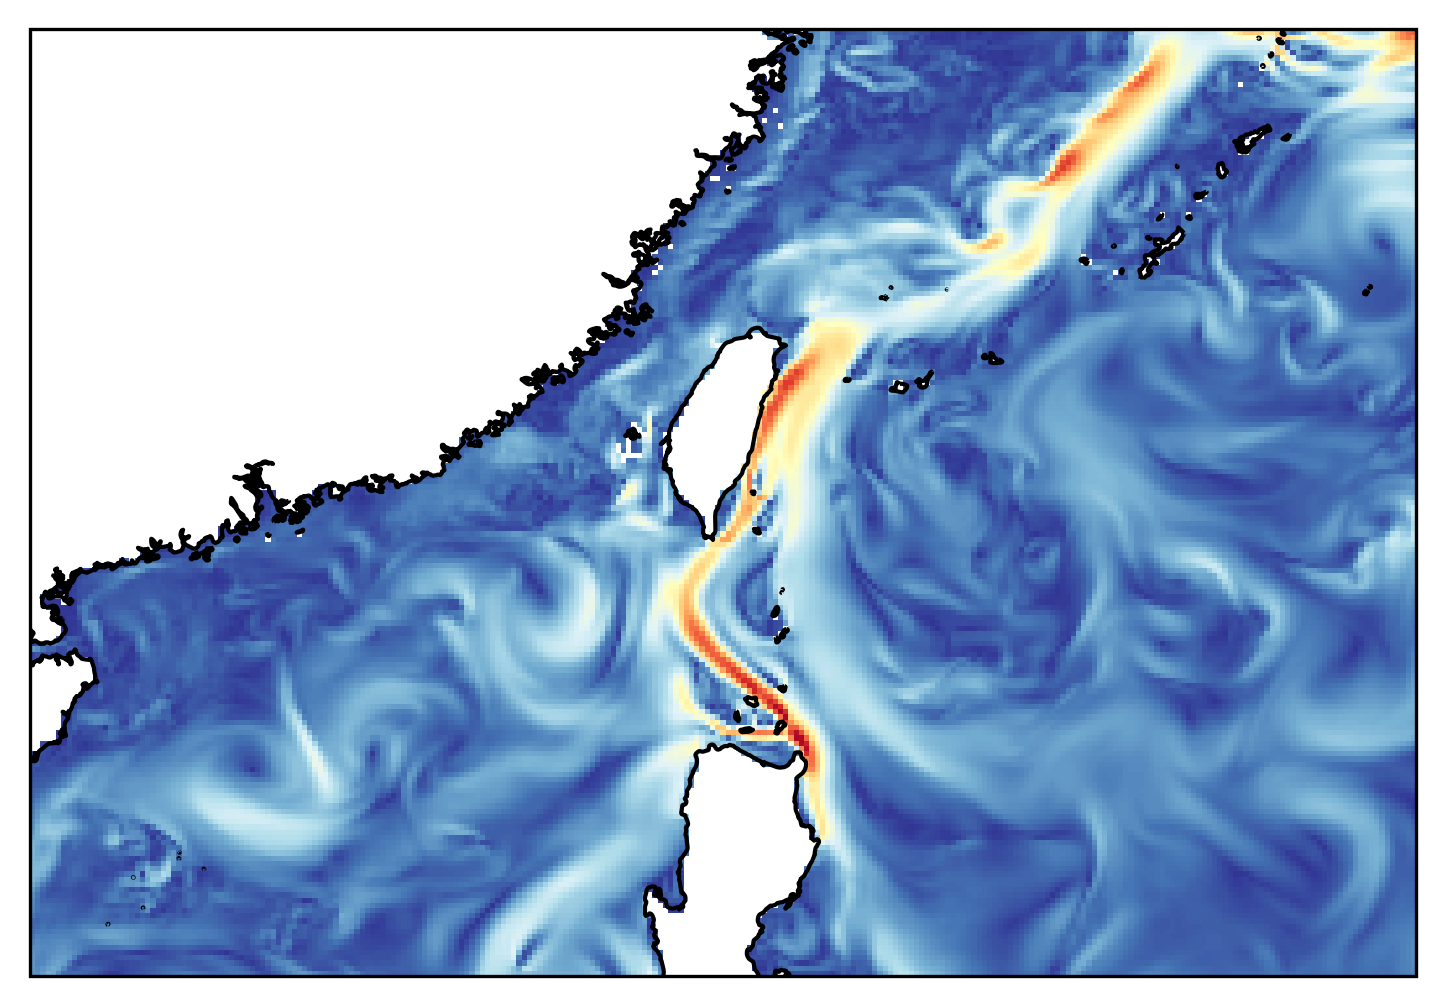

In [21]:
w=6*2*2/4
h=w*float(new_u0.shape[0])/float(new_u0.shape[1])
plt.figure(dpi=300,figsize=(w,h))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.linspace(int(np.nanmin(new_speed)),int(np.nanmax(new_speed))+1,8)
# CS = ax.contourf(new_lon,new_lat,new_speed,levels,cmap='YlOrRd',alpha=1, extend='both',linewidths=0.4)
CS = ax.pcolormesh(new_lon,new_lat,new_speed, cmap='RdYlBu_r',transform=ccrs.PlateCarree())
# ax.clabel(CS, inline=True,fmt='%1.1f',inline_spacing=0, fontsize=2)
ax.add_feature(cfeature.LAND, color='white')  # Add this line to color the land in green

# ax.set_extent([110, 132, 15, 32], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

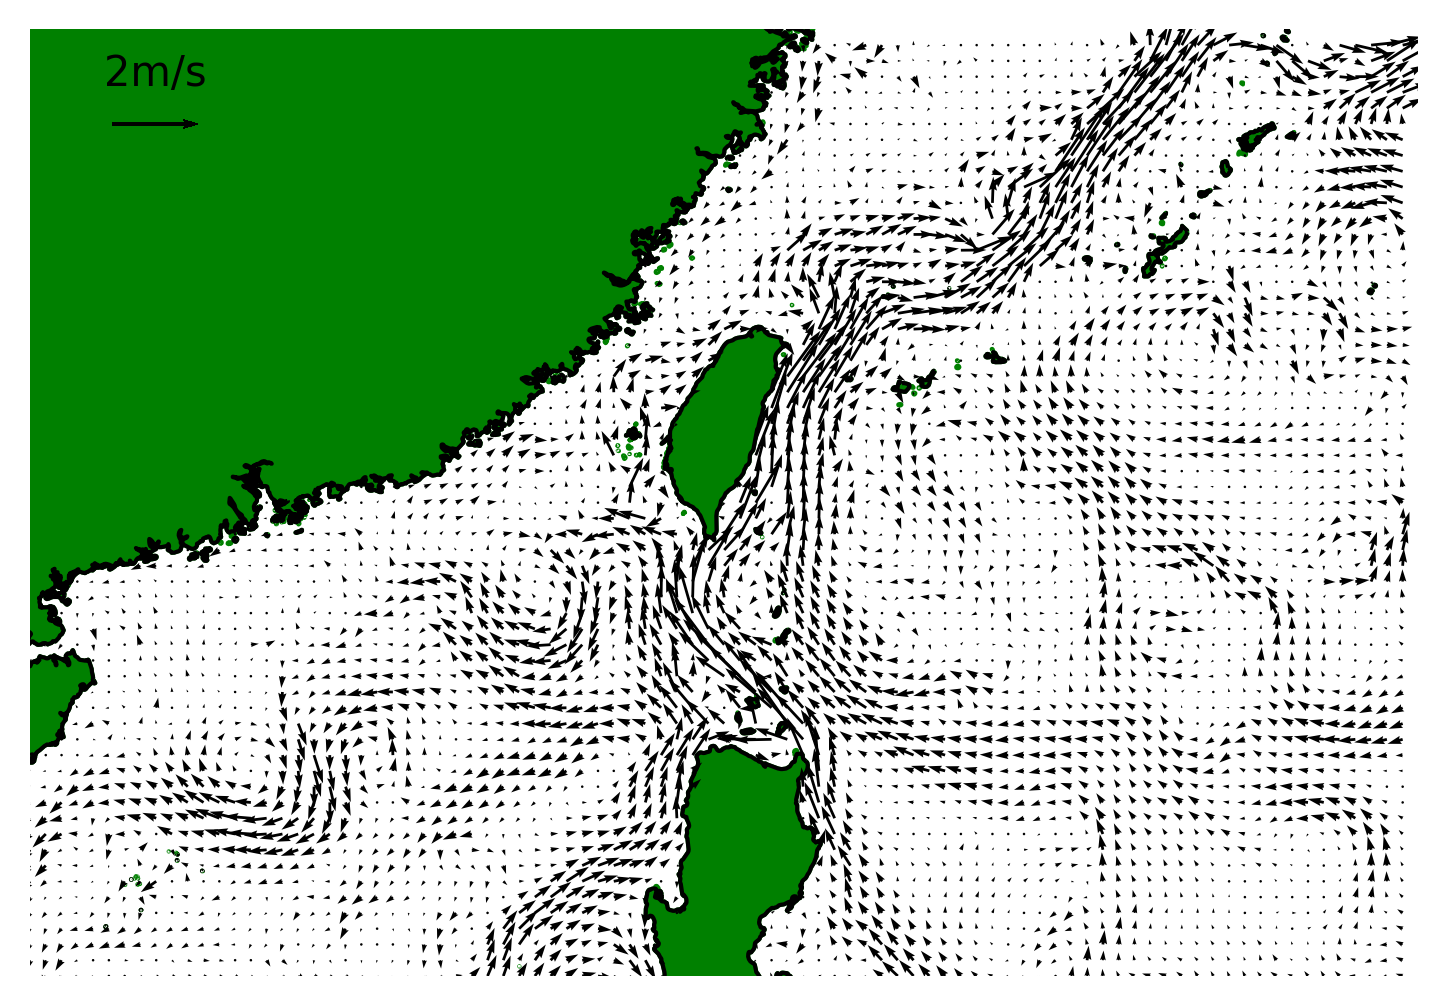

In [117]:
plot_ocean_current(new_u0,new_v0,new_lon,new_lat,3,width=0.002)

(109.41025015902689, 133.0581853913717, 14.296046134561516, 30.716094872151224)

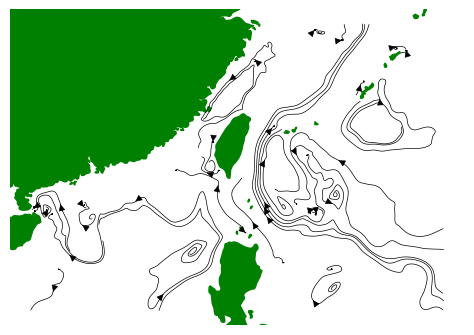

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy

from scipy.interpolate import griddata

# Assuming lon and lat are 1D arrays representing the original coordinates
# and new_u0 and new_v0 are the corresponding data values
# Create coordinate pairs
w=6*2*2/4
h=w*float(new_u0.shape[0])/float(new_u0.shape[1])
plt.figure(figsize=(w,h))
ax = plt.axes(projection=ccrs.PlateCarree())
# Add land feature and color it green
ax.add_feature(cfeature.LAND, color='green')

# Draw streamlines
ax.streamplot(new_lon,new_lat, new_u0,new_v0, density=120, linewidth=0.5, color='k', transform=ccrs.PlateCarree())
ax.axis('off')

In [141]:
np.shape(new_u0)

(181, 265)